In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify as squarify

from dotenv import load_dotenv
from sqlalchemy import create_engine

load_dotenv()

driver = os.getenv("DRIVER").replace("{", "").replace("}", "")
server = os.getenv("SERVER")
database = os.getenv("DATABASE")
trusted_connection = os.getenv("TRUSTED_CONNECTION")

connection_string = f"mssql+pyodbc://{server}/{database}?driver={driver}&trusted_connection={trusted_connection}"
engine = create_engine(connection_string)


**Contar empleados activos por turno**

Determina cuántos empleados están asignados a cada turno de trabajo (Shift) y visualiza los resultados

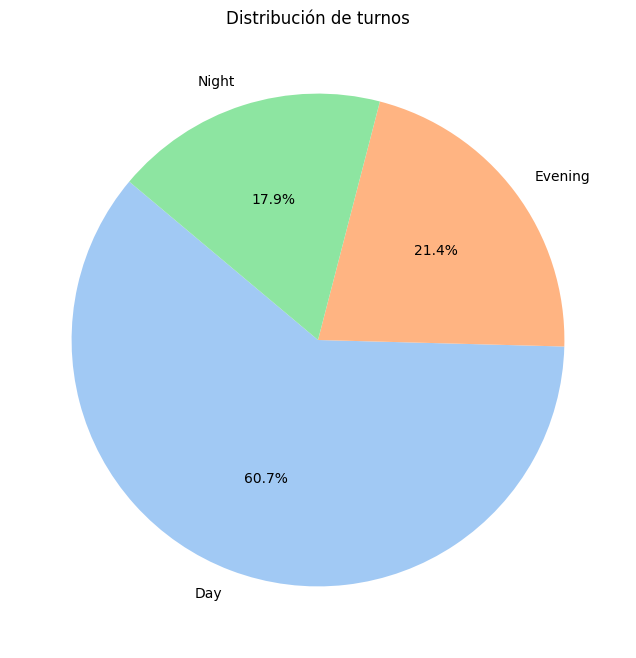

In [43]:
query = """
SELECT HRShift.Name AS Turno,count(*) as UsuariosActivosPorTurno
FROM HumanResources.EmployeeDepartmentHistory HRDepartmentHistory
JOIN HumanResources.Shift HRShift
	ON HRShift.ShiftID = HRDepartmentHistory.ShiftID
WHERE HRDepartmentHistory.EndDate IS NULL
GROUP BY HRShift.Name;
"""
df = pd.read_sql(query, engine)

# Crear gráfico
plt.figure(figsize=(8, 8))
plt.pie(df["UsuariosActivosPorTurno"], labels=df["Turno"], autopct="%1.1f%%", startangle=140, colors=sns.color_palette("pastel"))
plt.title("Distribución de turnos")
plt.show()

**Analizar la duración promedio de los turnos**

Calcula la duración promedio de los turnos en horas y analiza cuál es el turno más largo y el más corto.

**_No existen turno más largo ni más corto._**

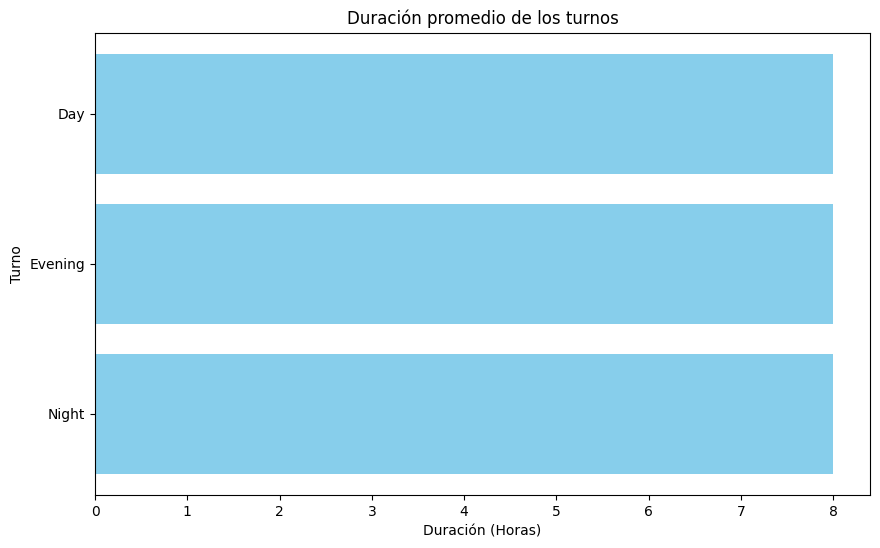

In [40]:
query = """
SELECT HRShift.Name AS Turno,
     CASE
        WHEN HRShift.EndTime < HRShift.StartTime THEN
            DATEDIFF(MINUTE,
                     CAST(HRShift.StartTime AS DATETIME),
                     DATEADD(DAY, 1, CAST(HRShift.EndTime AS DATETIME))) / 60
        ELSE
            DATEDIFF(MINUTE,
                     CAST(HRShift.StartTime AS DATETIME),
                     CAST(HRShift.EndTime AS DATETIME)) / 60
    END AS DuracionHoras
FROM HumanResources.Shift HRShift
ORDER BY DuracionHoras DESC;
"""
df = pd.read_sql(query, engine)

plt.figure(figsize=(10, 6))
plt.barh(df["Turno"], df["DuracionHoras"], color="skyblue")
plt.xlabel("Duración (Horas)")
plt.ylabel("Turno")
plt.title("Duración promedio de los turnos")
plt.gca().invert_yaxis()
plt.show()

**Historial de cambios de departamento**

Identifica cuántos empleados han cambiado de departamento al menos una vez y visualiza los cambios más frecuentes.

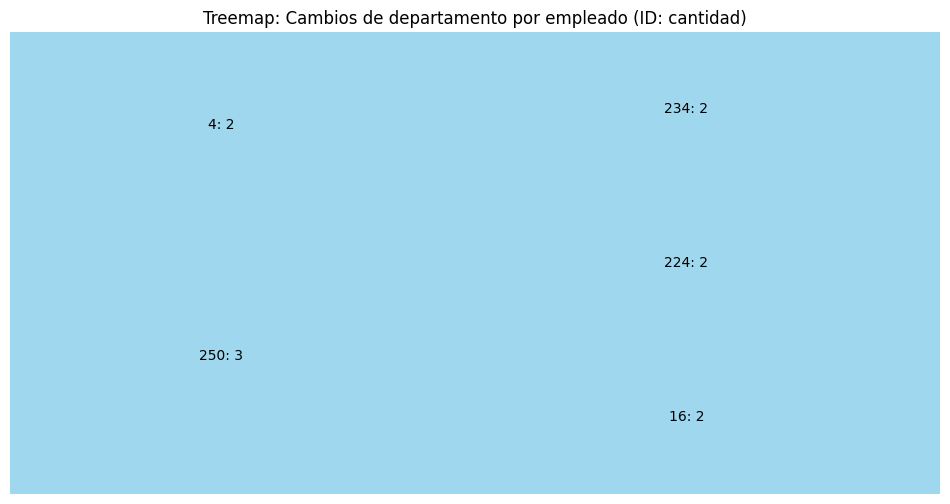

In [59]:

query = """
SELECT
    HRDepartmentHistory.BusinessEntityID,
    COUNT(*) AS CantidadCambios
FROM HumanResources.EmployeeDepartmentHistory HRDepartmentHistory
GROUP BY HRDepartmentHistory.BusinessEntityID
HAVING COUNT(*) > 1
ORDER BY CantidadCambios DESC;
"""
df = pd.read_sql(query, engine)
etiquetas = [f"{id}: {cambios}" for id, cambios in zip(df["BusinessEntityID"], df["CantidadCambios"])]
plt.figure(figsize=(12, 6))
squarify.plot(sizes=df["CantidadCambios"], label=etiquetas, alpha=0.8, color="skyblue")
plt.title("Treemap: Cambios de departamento por empleado (ID: cantidad)")
plt.axis("off")
plt.show()